In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt

In [0]:
letters = ['a', 'b', 'c', 'd']

def removeData(images, labels):
  '''Remove images and labels that are not a, b, c, or d'''
  arr_img = []
  arr_label = []
  for i in range(images.shape[0]):
    if labels[i][0].lower() in letters:
      arr_img.append(images[i])
      arr_label.append(labels[i][0].lower())
  return np.array(arr_img), np.array(arr_label)

In [0]:
# Load original data
X1 = np.load('train_data.npy')
y1 = np.load('train_labels.npy')
# Remove unnecessary data
X1, y1 = removeData(X1, y1)

# Load data we collected from lab 1
X2 = np.load('data.npy')
y2 = np.load('labels.npy')
# Remove unnecessary data
X2, y2 = removeData(X2, y2)

# Load data Raymond and Yadi collected
X3 = np.load('new_data.npy')
y3 = np.load('new_labels.npy')
# Remove unnecessary data
X3, y3 = removeData(X3, y3)

# Load data Suman collected
X4 = np.load('Suman_data.npy')
y4 = np.load('Suman_labels.npy')
# Remove unnecessary data
X4, y4 = removeData(X4, y4)

# Load data Natalia collected
X5 = np.load('nat_data.npy')
y5 = np.load('nat_labels.npy')
# Remove unnecessary data
X5, y5 = removeData(X5, y5)

In [4]:
X = np.concatenate((X1, X2, X3, X4, X5), axis=0)
y = np.concatenate((y1.reshape(-1, 1), y2.reshape(-1, 1), y3.reshape(-1, 1), 
                    y4.reshape(-1, 1), y5.reshape(-1, 1)), axis=0)
print(X.shape, y.shape)

# Pre-process and resize images
X = preprocess_input(X)
X_resized = np.array([resize(image, (96, 96)) for image in X])
print(X_resized.shape)

# Use one-hot encoding for labels
onehot_encoder = OneHotEncoder(sparse=False)
one_hot_y = onehot_encoder.fit_transform(y)

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_resized, one_hot_y, test_size=0.2)

(1176, 100, 100, 3) (1176, 1)
(1176, 96, 96, 3)


In [5]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{'a': 302, 'b': 301, 'c': 291, 'd': 282}

In [0]:
# Training data generator
datagen_train = ImageDataGenerator(
      zoom_range=[0.8,1.0], 
      horizontal_flip=True, 
      vertical_flip=True, 
      rotation_range=90
      )

In [0]:
# Validation data generator
datagen_val = ImageDataGenerator()

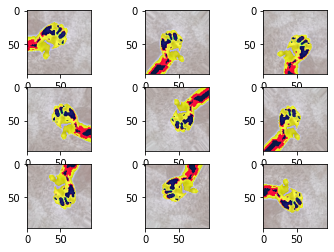

In [8]:
# Visualize augmented images

data = X_train[0]
# expand dimension to one sample
sample = expand_dims(data, 0)
# prepare iterator of image data augmentation generator
it = datagen_train.flow(sample)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

In [0]:
batch_size = 150

generator_train = datagen_train.flow(x=X_train, y=y_train,
                                    batch_size=batch_size,
                                    shuffle=True)

In [0]:
generator_val = datagen_val.flow(x=X_val, y=y_val,
                                  batch_size=batch_size,
                                  shuffle=False)

In [11]:
steps_val = generator_val.n / batch_size
steps_val

1.5733333333333333

In [0]:
IMG_SIZE = 96
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Load VGG-16 model
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False

In [13]:
num_classes = one_hot_y.shape[1]
num_classes

4

In [0]:
model = Sequential ([
    base_model,
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    Flatten(),
    # Add 2 fully-connected layers.
    # This is for combining features that the VGG16 model has
    Dense(4608, activation='relu'),
    Dense(1024, activation='relu'),   
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data
    Dropout(0.5),
    # Add the final layer for the actual classification.
    Dense(num_classes, activation='softmax')                          
])

In [0]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', 
                               patience=30, restore_best_weights=True, 
                               verbose=1)

In [17]:
epochs = 300
steps_per_epoch = 40

history = model.fit(x=generator_train, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=generator_val,
                    validation_steps=steps_val,
                    callbacks=[early_stopping])

Epoch 1/300
40/40 [==============================] - 11s 285ms/step - loss: 6.8425 - accuracy: 0.6103 - val_loss: 0.4141 - val_accuracy: 0.8390
Epoch 2/300
40/40 [==============================] - 10s 262ms/step - loss: 0.3521 - accuracy: 0.8798 - val_loss: 0.3082 - val_accuracy: 0.8898
Epoch 3/300
40/40 [==============================] - 11s 265ms/step - loss: 0.2169 - accuracy: 0.9277 - val_loss: 0.2628 - val_accuracy: 0.8941
Epoch 4/300
40/40 [==============================] - 11s 265ms/step - loss: 0.1666 - accuracy: 0.9439 - val_loss: 0.2394 - val_accuracy: 0.9280
Epoch 5/300
40/40 [==============================] - 11s 270ms/step - loss: 0.1364 - accuracy: 0.9564 - val_loss: 0.2261 - val_accuracy: 0.9195
Epoch 6/300
40/40 [==============================] - 10s 259ms/step - loss: 0.1211 - accuracy: 0.9618 - val_loss: 0.1217 - val_accuracy: 0.9619
Epoch 7/300
40/40 [==============================] - 10s 252ms/step - loss: 0.1580 - accuracy: 0.9545 - val_loss: 0.2218 - val_accuracy:

In [0]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, color='b', label='Training Acc.')
    # plt.plot(loss, '--', color='b', label='Training Loss')
    
    # Plot it for the validation set.
    plt.plot(val_acc, color='r', label='Validation Acc.')
    plt.plot(val_loss, '--', color='r', label='Validation Loss')

    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

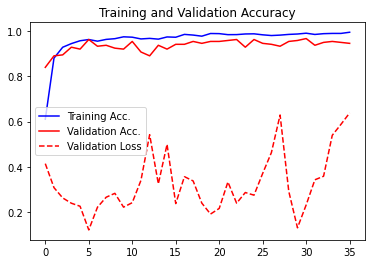

In [19]:
plot_training_history(history)

In [0]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)

In [21]:
y_true = np.argmax(y_val,axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[64,  1,  0,  0],
       [ 0, 55,  2,  1],
       [ 2,  0, 59,  1],
       [ 0,  0,  2, 49]])

In [22]:
score = accuracy_score(y_true, y_pred)
print('Validation Accuracy:', score)

target_names = np.unique(y)
print(classification_report(y_true, y_pred, target_names=target_names))

Validation Accuracy: 0.961864406779661
              precision    recall  f1-score   support

           a       0.97      0.98      0.98        65
           b       0.98      0.95      0.96        58
           c       0.94      0.95      0.94        62
           d       0.96      0.96      0.96        51

    accuracy                           0.96       236
   macro avg       0.96      0.96      0.96       236
weighted avg       0.96      0.96      0.96       236



In [0]:
# Unfreeze the pre-trained model for fine-tuning
base_model.trainable = True

In [0]:
for layer in base_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [25]:
for layer in base_model.layers:
    print("{0}:\t{1}".format(layer.trainable, layer.name))

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [0]:
model.compile(optimizer=Adam(lr=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
epochs = 500
steps_per_epoch = 40

history = model.fit(x=generator_train, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=generator_val,
                    validation_steps=steps_val,
                    callbacks=[early_stopping])

Epoch 1/500
40/40 [==============================] - 11s 274ms/step - loss: 0.1044 - accuracy: 0.9657 - val_loss: 0.1211 - val_accuracy: 0.9661
Epoch 2/500
40/40 [==============================] - 11s 264ms/step - loss: 0.1082 - accuracy: 0.9665 - val_loss: 0.1161 - val_accuracy: 0.9661
Epoch 3/500
40/40 [==============================] - 10s 262ms/step - loss: 0.1060 - accuracy: 0.9676 - val_loss: 0.1139 - val_accuracy: 0.9661
Epoch 4/500
40/40 [==============================] - 11s 271ms/step - loss: 0.1107 - accuracy: 0.9655 - val_loss: 0.1118 - val_accuracy: 0.9661
Epoch 5/500
40/40 [==============================] - 11s 267ms/step - loss: 0.1053 - accuracy: 0.9699 - val_loss: 0.1104 - val_accuracy: 0.9661
Epoch 6/500
40/40 [==============================] - 10s 261ms/step - loss: 0.1011 - accuracy: 0.9713 - val_loss: 0.1102 - val_accuracy: 0.9661
Epoch 7/500
40/40 [==============================] - 11s 269ms/step - loss: 0.0903 - accuracy: 0.9690 - val_loss: 0.1097 - val_accuracy:

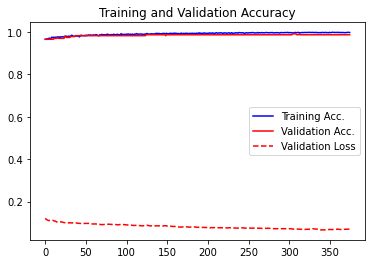

In [28]:
plot_training_history(history)

In [29]:
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_train,axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[237,   0,   0,   0],
       [  0, 243,   0,   0],
       [  0,   0, 229,   0],
       [  0,   0,   0, 231]])

In [30]:
score = accuracy_score(y_true, y_pred)
print('Training Accuracy:', score)
print(classification_report(y_true, y_pred, target_names=target_names))

Training Accuracy: 1.0
              precision    recall  f1-score   support

           a       1.00      1.00      1.00       237
           b       1.00      1.00      1.00       243
           c       1.00      1.00      1.00       229
           d       1.00      1.00      1.00       231

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940



In [31]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_val,axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[65,  0,  0,  0],
       [ 0, 58,  0,  0],
       [ 0,  0, 61,  1],
       [ 0,  0,  2, 49]])

In [32]:
score = accuracy_score(y_true, y_pred)
print('Validation Accuracy:', score)
print(classification_report(y_true, y_pred, target_names=target_names))

Validation Accuracy: 0.9872881355932204
              precision    recall  f1-score   support

           a       1.00      1.00      1.00        65
           b       1.00      1.00      1.00        58
           c       0.97      0.98      0.98        62
           d       0.98      0.96      0.97        51

    accuracy                           0.99       236
   macro avg       0.99      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236



In [33]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
model.save('/content/drive/My Drive/model1.h5') 